# **PARTICLE SWARM OPTIMIZATION**

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from hyperopt import hp, tpe, Trials, fmin
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score


def objective(params, model_name, X, y):
    if model_name == 'RandomForest':
        n_estimators, max_depth = params
        model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'ANN':
        hidden_layer_sizes, alpha = params
        model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        n_neighbors = params[0]
        model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
    elif model_name == 'LogisticRegression':
        C = params[0]
        model = LogisticRegression(C=C, max_iter=1000)
    elif model_name == 'XGBoost':
        n_estimators, max_depth, learning_rate = params
        model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'DecisionTree':
        max_depth = params[0]
        model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
    elif model_name == 'GradientBoosting':
        n_estimators, max_depth, learning_rate = params
        model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
    elif model_name == 'AdaBoost':
        n_estimators, learning_rate = params
        model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
    elif model_name == 'ExtraTrees':
        n_estimators, max_depth = params
        model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
    elif model_name == 'Bagging':
        n_estimators = params[0]
        model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
    elif model_name == 'GaussianNB':
        model = GaussianNB()

    score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
    return -score

def pso(objective, bounds, model_name, X, y, n_particles=30, n_iterations=10, w=0.5, c1=0.8, c2=0.9):
    dim = bounds.shape[0]
    swarm = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_particles, dim))
    velocity = np.random.uniform(-1, 1, (n_particles, dim))
    personal_best_positions = swarm.copy()
    personal_best_scores = np.array([objective(p, model_name, X, y) for p in swarm])
    global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
    global_best_score = np.min(personal_best_scores)

    for i in range(n_iterations):
        for j in range(n_particles):
            r1, r2 = np.random.rand(2)
            velocity[j] = (w * velocity[j] +
                           c1 * r1 * (personal_best_positions[j] - swarm[j]) +
                           c2 * r2 * (global_best_position - swarm[j]))
            swarm[j] = swarm[j] + velocity[j]
            swarm[j] = np.clip(swarm[j], bounds[:, 0], bounds[:, 1])

            score = objective(swarm[j], model_name, X, y)
            if score < personal_best_scores[j]:
                personal_best_positions[j] = swarm[j]
                personal_best_scores[j] = score

        global_best_position = personal_best_positions[np.argmin(personal_best_scores)]
        global_best_score = np.min(personal_best_scores)

    return global_best_position, -global_best_score

bounds_dict = {
    'RandomForest': np.array([[10, 200], [1, 20]]),
    'ANN': np.array([[10, 200], [1e-6, 1]]),
    'KNN': np.array([[1, 50]]),
    'LogisticRegression': np.array([[1e-6, 1e+2]]),
    'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'DecisionTree': np.array([[1, 20]]),
    'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
    'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
    'ExtraTrees': np.array([[10, 200], [1, 20]]),
    'Bagging': np.array([[10, 200]]),
}

def HPO(model_name, X, y):
    bounds = bounds_dict[model_name]
    best_params, optimized_accuracy = pso(objective, bounds, model_name, X, y)

    default_model = None
    if model_name == 'RandomForest':
        default_model = RandomForestClassifier(random_state=42)
    elif model_name == 'ANN':
        default_model = MLPClassifier(max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        default_model = KNeighborsClassifier()
    elif model_name == 'LogisticRegression':
        default_model = LogisticRegression(max_iter=1000)
    elif model_name == 'XGBoost':
        default_model = XGBClassifier(random_state=42)
    elif model_name == 'DecisionTree':
        default_model = DecisionTreeClassifier(random_state=42)
    elif model_name == 'GradientBoosting':
        default_model = GradientBoostingClassifier(random_state=42)
    elif model_name == 'AdaBoost':
        default_model = AdaBoostClassifier(random_state=42)
    elif model_name == 'ExtraTrees':
        default_model = ExtraTreesClassifier(random_state=42)
    elif model_name == 'Bagging':
        default_model = BaggingClassifier(random_state=42)
    elif model_name == 'GaussianNB':
        default_model = GaussianNB()

    default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

    return {
        'optimized_params': best_params,
        'optimized_accuracy': optimized_accuracy,
        'default_accuracy': default_accuracy
    }

def optimize_model(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    bounds = bounds_dict[model_name]
    best_params, _ = pso(objective, bounds, model_name, X_preprocessed, y)

    model = None
    if model_name == 'RandomForest':
        model = RandomForestClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
    elif model_name == 'ANN':
        model = MLPClassifier(hidden_layer_sizes=(int(best_params[0]),), alpha=best_params[1], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        model = KNeighborsClassifier(n_neighbors=int(best_params[0]))
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(C=best_params[0], max_iter=1000)
    elif model_name == 'XGBoost':
        model = XGBClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
    elif model_name == 'DecisionTree':
        model = DecisionTreeClassifier(max_depth=int(best_params[0]), random_state=42)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), learning_rate=best_params[2], random_state=42)
    elif model_name == 'AdaBoost':
        model = AdaBoostClassifier(n_estimators=int(best_params[0]), learning_rate=best_params[1], random_state=42)
    elif model_name == 'ExtraTrees':
        model = ExtraTreesClassifier(n_estimators=int(best_params[0]), max_depth=int(best_params[1]), random_state=42)
    elif model_name == 'Bagging':
        model = BaggingClassifier(n_estimators=int(best_params[0]), random_state=42)
    elif model_name == 'GaussianNB':
        model = GaussianNB()

    if model is not None:
        roc_auc_optimized = cross_val_score(model, X_preprocessed, y, cv=5, scoring='roc_auc').mean()
        accuracy_optimized = cross_val_score(model, X_preprocessed, y, cv=5, scoring='accuracy').mean()
        print(f"Optimization Results for {model_name} on dataset {dataset}:")
        print(f"  Optimized Parameters: {best_params}")
        print(f"  Optimized Accuracy: {accuracy_optimized}")
        print(f"  Optimized ROC AUC: {roc_auc_optimized}")

        default_model = model.__class__()
        roc_auc_default = cross_val_score(default_model, X_preprocessed, y, cv=5, scoring='roc_auc').mean()
        accuracy_default = cross_val_score(default_model, X_preprocessed, y, cv=5, scoring='accuracy').mean()
        print(f"  Default Accuracy: {accuracy_default}")
        print(f"  Default ROC AUC: {roc_auc_default}")
 






FINDING ACCURACY USING HYPEROPT FOR COMAPRISON

In [2]:
def HPO_hyperopt(model_name, X, y):
    space = {
        
    'RandomForest': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'ANN': {
        'hidden_layer_sizes': hp.quniform('hidden_layer_sizes', 10, 200, 1),
        'alpha': hp.uniform('alpha', 1e-6, 1)
    },
    'KNN': {
        'n_neighbors': hp.quniform('n_neighbors', 1, 50, 1)
    },
    'LogisticRegression': {
        'C': hp.loguniform('C', np.log(1e-6), np.log(1e+2))
    },
    'XGBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'DecisionTree': {
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'GradientBoosting': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'AdaBoost': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.5)
    },
    'ExtraTrees': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
        'max_depth': hp.quniform('max_depth', 1, 20, 1)
    },
    'Bagging': {
        'n_estimators': hp.quniform('n_estimators', 10, 200, 1)
    }
}
        
    
    def objective_hyperopt(params):
        if model_name == 'RandomForest':
            model = RandomForestClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'ANN':
            model = MLPClassifier(hidden_layer_sizes=(int(params['hidden_layer_sizes']),), alpha=params['alpha'], max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            model = KNeighborsClassifier(n_neighbors=int(params['n_neighbors']))
        elif model_name == 'LogisticRegression':
            model = LogisticRegression(C=params['C'], max_iter=1000)
        elif model_name == 'XGBoost':
            model = XGBClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'DecisionTree':
            model = DecisionTreeClassifier(max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'GradientBoosting':
            model = GradientBoostingClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'AdaBoost':
            model = AdaBoostClassifier(n_estimators=int(params['n_estimators']), learning_rate=params['learning_rate'], random_state=42)
        elif model_name == 'ExtraTrees':
            model = ExtraTreesClassifier(n_estimators=int(params['n_estimators']), max_depth=int(params['max_depth']), random_state=42)
        elif model_name == 'Bagging':
            model = BaggingClassifier(n_estimators=int(params['n_estimators']), random_state=42)
        
        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    trials = Trials()
    best_params = fmin(objective_hyperopt, space[model_name], algo=tpe.suggest, max_evals=20, trials=trials)

    best_params_values = {key: best_params[key] for key in space[model_name]}
    
    best_model = None
    if model_name == 'RandomForest':
        best_model = RandomForestClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'ANN':
        best_model = MLPClassifier(hidden_layer_sizes=(int(best_params_values['hidden_layer_sizes']),), alpha=best_params_values['alpha'], max_iter=1000, random_state=42)
    elif model_name == 'KNN':
        best_model = KNeighborsClassifier(n_neighbors=int(best_params_values['n_neighbors']))
    elif model_name == 'LogisticRegression':
        best_model = LogisticRegression(C=best_params_values['C'], max_iter=1000)
    elif model_name == 'XGBoost':
        best_model = XGBClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'DecisionTree':
        best_model = DecisionTreeClassifier(max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'GradientBoosting':
        best_model = GradientBoostingClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'AdaBoost':
        best_model = AdaBoostClassifier(n_estimators=int(best_params_values['n_estimators']), learning_rate=best_params_values['learning_rate'], random_state=42)
    elif model_name == 'ExtraTrees':
        best_model = ExtraTreesClassifier(n_estimators=int(best_params_values['n_estimators']), max_depth=int(best_params_values['max_depth']), random_state=42)
    elif model_name == 'Bagging':
        best_model = BaggingClassifier(n_estimators=int(best_params_values['n_estimators']), random_state=42)

    best_model.fit(X, y)
    
    return best_params_values, best_model

def optimize_model_hyperopt(model_name, dataset, target_column):
    data = pd.read_csv(dataset)
    X = data.drop(columns=[target_column])
    y = data[target_column]

    le = LabelEncoder()
    y = le.fit_transform(y)

    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    numerical_cols = X.select_dtypes(include=['number']).columns

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

    X_preprocessed = preprocessor.fit_transform(X)

    best_params_hyperopt, best_model_hyperopt = HPO_hyperopt(model_name, X_preprocessed, y)

    cross_val_scores_hyperopt = cross_val_score(best_model_hyperopt, X_preprocessed, y, cv=5, scoring='accuracy').mean()

    y_pred_hyperopt = cross_val_predict(best_model_hyperopt, X_preprocessed, y, cv=5, method='predict_proba')[:, 1]
    roc_auc_hyperopt = roc_auc_score(y, y_pred_hyperopt)

    print(f"Optimization Results for {model_name} using Hyperopt on dataset {dataset}:")
    print(f"  Optimized Parameters-Hyperopt: {best_params_hyperopt}")
    print(f"  Accuracy - Hyperopt: {cross_val_scores_hyperopt}")
    print(f"  ROC-AUC Score - Hyperopt: {roc_auc_hyperopt}")




TESTING PSO OPTIMIZATION AND COMAPIRNG RESULTS WITH HYPEROPT ON VARIOUS ML MODELS

KNN

In [3]:

optimize_model('KNN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('KNN', 'mushrooms.csv', 'class')


Optimization Results for KNN on dataset mushrooms.csv:
  Optimized Parameters: [2.31301632]
  Optimized Accuracy: 0.9545764304660856
  Optimized ROC AUC: 0.9569285532286635
  Default Accuracy: 0.9278522925350512
  Default ROC AUC: 0.9671154966148171
100%|██████████| 20/20 [00:52<00:00,  2.63s/trial, best loss: -0.9508807881773398]
Optimization Results for KNN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_neighbors': 1.0}
  Accuracy - Hyperopt: 0.9508807881773398
  ROC-AUC Score - Hyperopt: 0.9504018805563216


ANN

In [4]:

optimize_model('ANN', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ANN', 'mushrooms.csv', 'class')


Optimization Results for ANN on dataset mushrooms.csv:
  Optimized Parameters: [1.56310537e+02 2.65469423e-02]
  Optimized Accuracy: 0.9328935202728307
  Optimized ROC AUC: 0.9984203568626142
  Default Accuracy: 0.8989068586585829
  Default ROC AUC: 0.9983273777253645
100%|██████████| 20/20 [05:27<00:00, 16.39s/trial, best loss: -0.9214402425161046]
Optimization Results for ANN using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'hidden_layer_sizes': 139.0, 'alpha': 0.18167173156672062}
  Accuracy - Hyperopt: 0.9214402425161046
  ROC-AUC Score - Hyperopt: 0.9884151060094688


LOGISTIC REGRESSION

In [5]:

optimize_model('LogisticRegression', 'mushrooms.csv', 'class')
optimize_model_hyperopt('LogisticRegression', 'mushrooms.csv', 'class')


Optimization Results for LogisticRegression on dataset mushrooms.csv:
  Optimized Parameters: [93.60425526]
  Optimized Accuracy: 0.9423687760515348
  Optimized ROC AUC: 0.9979380503961257
  Default Accuracy: 0.9193427813565744
  Default ROC AUC: 0.9977293960850657
100%|██████████| 20/20 [00:01<00:00, 13.21trial/s, best loss: -0.9423687760515348]
Optimization Results for LogisticRegression using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'C': 94.53372066727107}
  Accuracy - Hyperopt: 0.9423687760515348
  ROC-AUC Score - Hyperopt: 0.9914823095849337


RANDOM FOREST

In [6]:

optimize_model('RandomForest', 'mushrooms.csv', 'class')
optimize_model_hyperopt('RandomForest', 'mushrooms.csv', 'class')


Optimization Results for RandomForest on dataset mushrooms.csv:
  Optimized Parameters: [10.         10.13283575]
  Optimized Accuracy: 0.9475495263357333
  Optimized ROC AUC: 0.9995371443459866
  Default Accuracy: 0.9311771883289126
  Default ROC AUC: 0.9997860298282619
100%|██████████| 20/20 [00:17<00:00,  1.15trial/s, best loss: -0.9365957559681698]
Optimization Results for RandomForest using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 91.0, 'max_depth': 10.0}
  Accuracy - Hyperopt: 0.9365957559681698
  ROC-AUC Score - Hyperopt: 0.9883358513575969


XGBOOST

In [7]:
optimize_model('XGBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('XGBoost', 'mushrooms.csv', 'class')


Optimization Results for XGBoost on dataset mushrooms.csv:
  Optimized Parameters: [200.           2.40970353   0.26357527]
  Optimized Accuracy: 0.988793558165972
  Optimized ROC AUC: 0.9997579358028741
  Default Accuracy: 0.9602221295945433
  Default ROC AUC: 0.9973661471549864
100%|██████████| 20/20 [00:04<00:00,  4.67trial/s, best loss: -0.9838733611216369]
Optimization Results for XGBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 164.0, 'max_depth': 2.0, 'learning_rate': 0.0306621185211162}
  Accuracy - Hyperopt: 0.9838733611216369
  ROC-AUC Score - Hyperopt: 0.9964230421552216


DECISION TREE

In [8]:
optimize_model('DecisionTree', 'mushrooms.csv', 'class')
optimize_model_hyperopt('DecisionTree', 'mushrooms.csv', 'class')


Optimization Results for DecisionTree on dataset mushrooms.csv:
  Optimized Parameters: [9.43880603]
  Optimized Accuracy: 0.996182796513831
  Optimized ROC AUC: 0.9962522570132558
  Default Accuracy: 0.9963058734369079
  Default ROC AUC: 0.9450125511956665
100%|██████████| 20/20 [00:00<00:00, 27.02trial/s, best loss: -0.996182796513831]
Optimization Results for DecisionTree using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'max_depth': 9.0}
  Accuracy - Hyperopt: 0.996182796513831
  ROC-AUC Score - Hyperopt: 0.9962545198211878


GRADIENT BOOSTING

In [9]:
optimize_model('GradientBoosting', 'mushrooms.csv', 'class')
optimize_model_hyperopt('GradientBoosting', 'mushrooms.csv', 'class')


Optimization Results for GradientBoosting on dataset mushrooms.csv:
  Optimized Parameters: [110.29818103   1.58584164   0.22758276]
  Optimized Accuracy: 0.9970461538461539
  Optimized ROC AUC: 0.9999872589437665
  Default Accuracy: 0.9566502463054187
  Default ROC AUC: 1.0
100%|██████████| 20/20 [00:41<00:00,  2.07s/trial, best loss: -0.9963058734369079]
Optimization Results for GradientBoosting using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 67.0, 'max_depth': 14.0, 'learning_rate': 0.3937273157558086}
  Accuracy - Hyperopt: 0.9963058734369079
  ROC-AUC Score - Hyperopt: 0.9994924303918408


ADA BOOST

In [10]:
optimize_model('AdaBoost', 'mushrooms.csv', 'class')
optimize_model_hyperopt('AdaBoost', 'mushrooms.csv', 'class')


Optimization Results for AdaBoost on dataset mushrooms.csv:
  Optimized Parameters: [133.72065264   0.35277411]
  Optimized Accuracy: 0.9507583175445244
  Optimized ROC AUC: 0.9941920863360856
  Default Accuracy: 0.9406585827965138
  Default ROC AUC: 0.9994952187005982
100%|██████████| 20/20 [00:26<00:00,  1.35s/trial, best loss: -0.9506316786661614]
Optimization Results for AdaBoost using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 23.0, 'learning_rate': 0.10162479506141603}
  Accuracy - Hyperopt: 0.9506316786661614
  ROC-AUC Score - Hyperopt: 0.9812426207001015


EXTRA TREES

In [11]:
optimize_model('ExtraTrees', 'mushrooms.csv', 'class')
optimize_model_hyperopt('ExtraTrees', 'mushrooms.csv', 'class')


Optimization Results for ExtraTrees on dataset mushrooms.csv:
  Optimized Parameters: [138.97031369   7.12614252]
  Optimized Accuracy: 0.9453399772641152
  Optimized ROC AUC: 0.9998302209708992
  Default Accuracy: 0.9325317165593028
  Default ROC AUC: 0.9995450286483128
100%|██████████| 20/20 [00:13<00:00,  1.44trial/s, best loss: -0.9373401288366805]
Optimization Results for ExtraTrees using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 79.0, 'max_depth': 6.0}
  Accuracy - Hyperopt: 0.9373401288366805
  ROC-AUC Score - Hyperopt: 0.9901121022460259


BAGGING

In [12]:
optimize_model('Bagging', 'mushrooms.csv', 'class')
optimize_model_hyperopt('Bagging', 'mushrooms.csv', 'class')


Optimization Results for Bagging on dataset mushrooms.csv:
  Optimized Parameters: [26.53423708]
  Optimized Accuracy: 0.9438428192497158
  Optimized ROC AUC: 0.9988774538612579
  Default Accuracy: 0.9423649867374004
  Default ROC AUC: 0.9951754206131179
100%|██████████| 20/20 [01:03<00:00,  3.18s/trial, best loss: -0.9418723758999621]
Optimization Results for Bagging using Hyperopt on dataset mushrooms.csv:
  Optimized Parameters-Hyperopt: {'n_estimators': 24.0}
  Accuracy - Hyperopt: 0.9418723758999621
  ROC-AUC Score - Hyperopt: 0.9988059613091654


PLOTTING LEARNING RATE DISTRIBUTION CURVES

In [13]:

def PLOT(model_name, dataset, target):
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    import matplotlib.pyplot as plt

    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()

        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def PSO(model_name, X, y, bounds, n_particles=30, n_iterations=5, w=0.5, c1=1, c2=2):
        dim = bounds.shape[0]
        particles = np.random.uniform(bounds[:, 0], bounds[:, 1], (n_particles, dim))
        velocities = np.random.uniform(-1, 1, (n_particles, dim))
        personal_best_positions = particles.copy()
        personal_best_scores = np.array([objective(p, model_name, X, y) for p in particles])

        global_best_index = np.argmin(personal_best_scores)
        global_best_position = personal_best_positions[global_best_index].copy()
        global_best_score = personal_best_scores[global_best_index]

        learning_rates = []
        accuracies = []

        for i in range(n_iterations):
            for j in range(n_particles):
                velocities[j] = (w * velocities[j] +
                                 c1 * np.random.random() * (personal_best_positions[j] - particles[j]) +
                                 c2 * np.random.random() * (global_best_position - particles[j]))
                particles[j] += velocities[j]
                particles[j] = np.clip(particles[j], bounds[:, 0], bounds[:, 1])

                score = objective(particles[j], model_name, X, y)
                if score < personal_best_scores[j]:
                    personal_best_scores[j] = score
                    personal_best_positions[j] = particles[j].copy()

                    if score < global_best_score:
                        global_best_score = score
                        global_best_position = particles[j].copy()

            if model_name in ['XGBoost', 'GradientBoosting']:
                learning_rate = global_best_position[-1]
                learning_rates.append(learning_rate)
                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(global_best_position[0]), max_depth=int(global_best_position[1]),
                                          learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(global_best_position[0]), max_depth=int(global_best_position[1]),
                                                       learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

        best_params = global_best_position
        optimized_accuracy = -global_best_score
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model = LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
                        default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }

    def plot_learning_rate_accuracy(learning_rates, accuracies):
        iterations = range(1, len(learning_rates) + 1)
        plt.plot(iterations, learning_rates, marker='o', label='Learning Rate')
        plt.plot(iterations, accuracies, marker='x', label='Accuracy')
        plt.xlabel('Iteration')
        plt.ylabel('Value')
        plt.title('Learning Rate and Accuracy vs Iteration')
        plt.legend()
        plt.grid(True)
        plt.show()

    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        bounds = bounds_dict[model_name]
        results = PSO(model_name, X_preprocessed, y, bounds)
        plot_learning_rate_accuracy(results['learning_rates'], results['accuracies'])

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),
        'Bagging': np.array([[10, 200]]),
    }

    optimize_model(model_name, dataset, target)


LEARNING RATE DISTRIBUTION CURVE -> XGBOOST

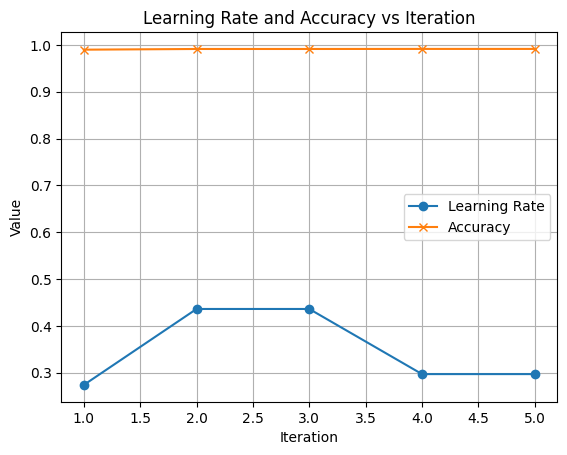

In [14]:
PLOT('XGBoost','mushrooms.csv','class')

LEARNING RATE DISTRIBUTION CURVE -> GRADIENT BOOSTING

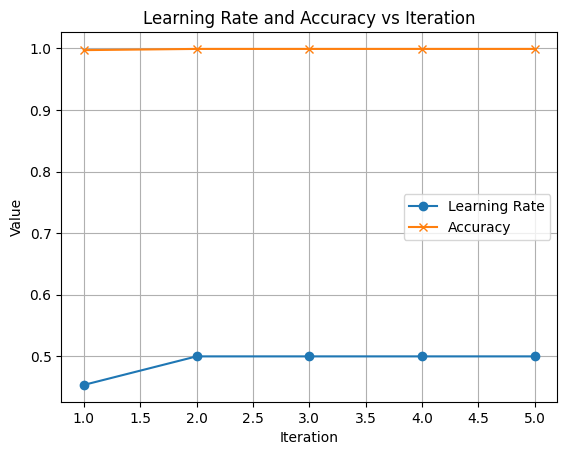

In [15]:
PLOT('GradientBoosting','mushrooms.csv','class')

## Learning Rate Curve for GradientBoosting PSO vs HyperOpt

<img src="gradientPSO.png" alt="PSO Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="gradientHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">



## Learning Rate Curve for XGBoost PSO vs HyperOpt

<img src="xgPSO2.png" alt="PSO Optimization" style="width: 45%; float: left; margin-right: 5%;">
<img src="xgHyperOpt.png" alt="HyperOpt Optimization" style="width: 45%; float: left;">



PLOTTING HISTOGRAM OF LEARNING RATE VS DENSITY

In [7]:
def PLOT_HIST(model_name, dataset, target):
    import numpy as np
    from sklearn.model_selection import cross_val_score
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.neural_network import MLPClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.preprocessing import LabelEncoder
    import pandas as pd
    from sklearn.preprocessing import OneHotEncoder, StandardScaler
    from sklearn.compose import ColumnTransformer
    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    import matplotlib.pyplot as plt

    def objective(params, model_name, X, y):
        if model_name == 'RandomForest':
            n_estimators, max_depth = params
            model = RandomForestClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'ANN':
            hidden_layer_sizes, alpha = params
            model = MLPClassifier(hidden_layer_sizes=(int(hidden_layer_sizes),), alpha=alpha, max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            n_neighbors = params[0]
            model = KNeighborsClassifier(n_neighbors=int(n_neighbors))
        elif model_name == 'LogisticRegression':
            C = params[0]
            model = LogisticRegression(C=C, max_iter=1000)
        elif model_name == 'XGBoost':
            n_estimators, max_depth, learning_rate = params
            model = XGBClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'DecisionTree':
            max_depth = params[0]
            model = DecisionTreeClassifier(max_depth=int(max_depth), random_state=42)
        elif model_name == 'GradientBoosting':
            n_estimators, max_depth, learning_rate = params
            model = GradientBoostingClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), learning_rate=learning_rate, random_state=42)
        elif model_name == 'AdaBoost':
            n_estimators, learning_rate = params
            model = AdaBoostClassifier(n_estimators=int(n_estimators), learning_rate=learning_rate, random_state=42)
        elif model_name == 'ExtraTrees':
            n_estimators, max_depth = params
            model = ExtraTreesClassifier(n_estimators=int(n_estimators), max_depth=int(max_depth), random_state=42)
        elif model_name == 'Bagging':
            n_estimators = params[0]
            model = BaggingClassifier(n_estimators=int(n_estimators), random_state=42)
        elif model_name == 'GaussianNB':
            model = GaussianNB()

        score = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
        return -score

    def PSO(model_name, X, y, bounds, n_particles=30, n_iterations=5, w=0.5, c1=1, c2=2):
        dim = bounds.shape[0]
        particles = np.random.uniform(bounds[:, 0], bounds[:, 1], (n_particles, dim))
        velocities = np.random.uniform(-1, 1, (n_particles, dim))
        personal_best_positions = particles.copy()
        personal_best_scores = np.array([objective(p, model_name, X, y) for p in particles])

        global_best_index = np.argmin(personal_best_scores)
        global_best_position = personal_best_positions[global_best_index].copy()
        global_best_score = personal_best_scores[global_best_index]

        learning_rates = []
        accuracies = []

        for i in range(n_iterations):
            for j in range(n_particles):
                velocities[j] = (w * velocities[j] +
                                 c1 * np.random.random() * (personal_best_positions[j] - particles[j]) +
                                 c2 * np.random.random() * (global_best_position - particles[j]))
                particles[j] += velocities[j]
                particles[j] = np.clip(particles[j], bounds[:, 0], bounds[:, 1])

                score = objective(particles[j], model_name, X, y)
                if score < personal_best_scores[j]:
                    personal_best_scores[j] = score
                    personal_best_positions[j] = particles[j].copy()

                    if score < global_best_score:
                        global_best_score = score
                        global_best_position = particles[j].copy()

            if model_name in ['XGBoost', 'GradientBoosting']:
                learning_rate = global_best_position[-1]
                learning_rates.append(learning_rate)
                if model_name == 'XGBoost':
                    model = XGBClassifier(n_estimators=int(global_best_position[0]), max_depth=int(global_best_position[1]),
                                          learning_rate=learning_rate, random_state=42)
                elif model_name == 'GradientBoosting':
                    model = GradientBoostingClassifier(n_estimators=int(global_best_position[0]), max_depth=int(global_best_position[1]),
                                                       learning_rate=learning_rate, random_state=42)
                accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy').mean()
                accuracies.append(accuracy)

        best_params = global_best_position
        optimized_accuracy = -global_best_score
        
        default_model = None
        if model_name == 'RandomForest':
            default_model = RandomForestClassifier(random_state=42)
        elif model_name == 'ANN':
            default_model = MLPClassifier(max_iter=1000, random_state=42)
        elif model_name == 'KNN':
            default_model = KNeighborsClassifier()
        elif model_name == 'LogisticRegression':
            default_model = LogisticRegression(max_iter=1000)
        elif model_name == 'XGBoost':
            default_model = XGBClassifier(random_state=42)
        elif model_name == 'DecisionTree':
            default_model = DecisionTreeClassifier(random_state=42)
        elif model_name == 'GradientBoosting':
            default_model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'AdaBoost':
            default_model = AdaBoostClassifier(random_state=42)
        elif model_name == 'ExtraTrees':
            default_model = ExtraTreesClassifier(random_state=42)
        elif model_name == 'Bagging':
            default_model = BaggingClassifier(random_state=42)
        elif model_name == 'GaussianNB':
            default_model = GaussianNB()
        
        default_accuracy = cross_val_score(default_model, X, y, cv=5, scoring='accuracy').mean() if default_model is not None else None

        return {
            'optimized_params': best_params,
            'optimized_accuracy': optimized_accuracy,
            'default_accuracy': default_accuracy,
            'learning_rates': learning_rates,
            'accuracies': accuracies
        }

    def plot_learning_rate_histogram(learning_rates):
        plt.hist(learning_rates, bins=10, alpha=0.6, color='g', edgecolor='black')
        plt.xlabel('Learning Rate')
        plt.ylabel('Frequency')
        plt.title('Learning Rate Frequency Histogram')
        plt.grid(True)
        plt.show()

    def optimize_model(model_name, dataset, target_column):
        data = pd.read_csv(dataset)
        X = data.drop(columns=[target_column])
        y = data[target_column]

        le = LabelEncoder()
        y = le.fit_transform(y)

        categorical_cols = X.select_dtypes(include=['object', 'category']).columns
        numerical_cols = X.select_dtypes(include=['number']).columns

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numerical_transformer, numerical_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])

        X_preprocessed = preprocessor.fit_transform(X)

        bounds = bounds_dict[model_name]
        results = PSO(model_name, X_preprocessed, y, bounds)
        plot_learning_rate_histogram(results['learning_rates'])

    bounds_dict = {
        'RandomForest': np.array([[10, 200], [1, 20]]),
        'ANN': np.array([[10, 200], [1e-6, 1]]),
        'KNN': np.array([[1, 50]]),
        'LogisticRegression': np.array([[1e-6, 1e+2]]),
        'XGBoost': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'DecisionTree': np.array([[1, 20]]),
        'GradientBoosting': np.array([[10, 200], [1, 20], [0.01, 0.5]]),
        'AdaBoost': np.array([[10, 200], [0.01, 0.5]]),
        'ExtraTrees': np.array([[10, 200], [1, 20]]),
        'Bagging': np.array([[10, 200]]),
    }

    optimize_model(model_name, dataset, target)


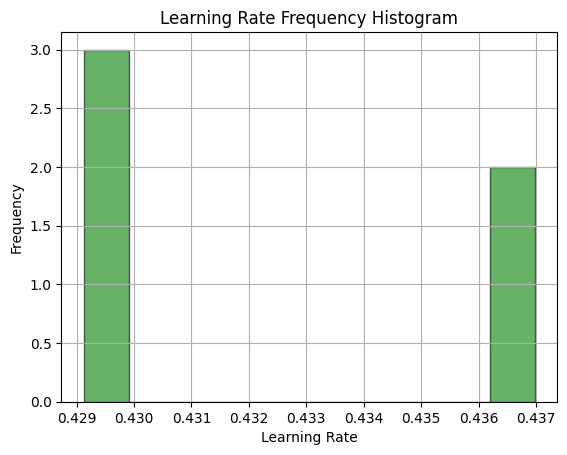

In [9]:
PLOT_HIST('XGBoost','mushrooms.csv','class')

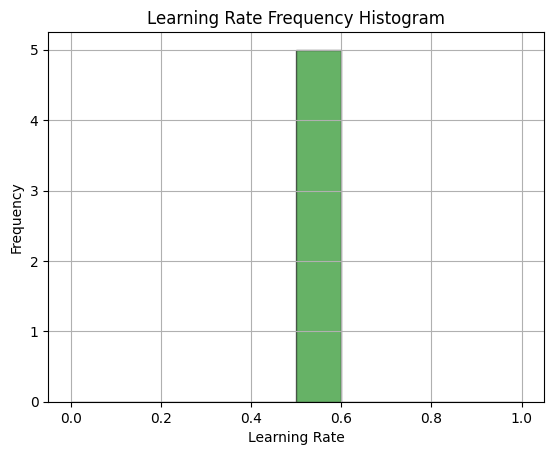

In [10]:
PLOT_HIST('GradientBoosting','mushrooms.csv','class')